In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt

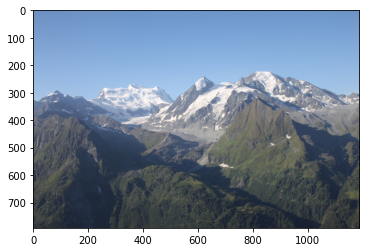

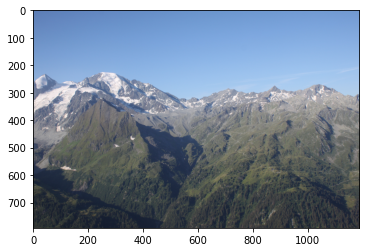

In [2]:
img1 = cv2.imread('data/IMG_4023.JPG')
img2 = cv2.imread('data/IMG_4024.JPG')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
height,width,channels = img1.shape
img1 = cv2.resize(img1,(round(0.25*width), round(0.25*height)), interpolation = cv2.INTER_LINEAR)
img2 = cv2.resize(img2,(round(0.25*width), round(0.25*height)), interpolation = cv2.INTER_LINEAR)

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

In [3]:
descriptor = cv2.SIFT_create()
(kp1, features1) = descriptor.detectAndCompute(img1, None)
(kp2, features2) = descriptor.detectAndCompute(img2, None)

In [4]:
#matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
matcher = cv2.BFMatcher()
ratio = 0.5
min_match = 1
raw_matches = matcher.knnMatch(features1, features2, k=2)
good_points = []
good_matches=[]
for m1, m2 in raw_matches:
    if m1.distance < ratio * m2.distance:
        good_points.append((m1.trainIdx, m1.queryIdx))
        good_matches.append([m1])
print(len(good_matches))
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
cv2.imwrite('matching.jpg', img3)
plt.figure(figsize=(20,10))
plt.imshow(img3)
plt.show()
if len(good_points) > min_match:
    image1_kp = np.float32([kp1[i].pt for (_, i) in good_points])
    image2_kp = np.float32([kp2[i].pt for (i, _) in good_points])
    H, status = cv2.findHomography(image1_kp, image2_kp, cv2.RANSAC,5.0)

593


In [5]:
    corners1 = np.array([
        [0,                         0,1],
        [0,             img1.shape[0],1],
        [img1.shape[1], img1.shape[0],1],
        [img1.shape[1],             0,1],
    ], dtype=np.float64)
    print(corners1)
    #corners1 = project_points(H, corners1)
    corners1 = np.matmul(H,corners1.T).T
    print("corners1: ", corners1)
    #corners1 = np.array([np.divide(corners1[:,0],corners1[:,2]) np.divide(corners1[:,1],corners1[:,2])])
    corners1 = np.array([np.divide(corners1[:,0],corners1[:,2]), np.divide(corners1[:,1],corners1[:,2])]).T
    print(H.shape, corners1.shape)
    print("corners1 dehom: ", corners1)
    corners2 = np.array([
        [0,                         0],
        [0,             img2.shape[0]],
        [img2.shape[1], img2.shape[0]],
        [img2.shape[1],             0],
    ], dtype=np.float64)
    print(corners2)

    
    x_cords = np.concatenate((corners1[:, 0], corners2[:, 0]))
    y_cords = np.concatenate((corners1[:, 1], corners2[:, 1]))
    print(y_cords)
    
    width = int(np.ceil(np.max(x_cords) - np.min(x_cords)))
    height = int(np.ceil(np.max(y_cords) - np.min(y_cords)))
    min_pointX = np.min(x_cords)
    min_pointY = np.min(y_cords)
    print(width, height, min_pointX, min_pointY)

    T = np.array([[1, 0, -min_pointX],[0, 1, -min_pointY],[0, 0, 1]])
    print("T: ", T)
    print("H: ", H)

[[0.000e+00 0.000e+00 1.000e+00]
 [0.000e+00 7.920e+02 1.000e+00]
 [1.188e+03 7.920e+02 1.000e+00]
 [1.188e+03 0.000e+00 1.000e+00]]
corners1:  [[-7.73889585e+02 -1.11489682e+02  1.00000000e+00]
 [-7.88012305e+02  8.76334347e+02  9.95534851e-01]
 [ 8.01122200e+02  1.03978243e+03  1.34144049e+00]
 [ 8.15244920e+02  5.19583957e+01  1.34590564e+00]]
(3, 3) (4, 2)
corners1 dehom:  [[-773.8895846  -111.48968195]
 [-791.54667841  880.26486089]
 [ 597.21039096  775.12378113]
 [ 605.72219648   38.60478342]]
[[   0.    0.]
 [   0.  792.]
 [1188.  792.]
 [1188.    0.]]
[-111.48968195  880.26486089  775.12378113   38.60478342    0.
  792.          792.            0.        ]
1980 992 -791.5466784081772 -111.48968194865037
T:  [[  1.           0.         791.54667841]
 [  0.           1.         111.48968195]
 [  0.           0.           1.        ]]
H:  [[ 1.33765531e+00 -1.78317174e-02 -7.73889585e+02]
 [ 1.37582557e-01  1.24725256e+00 -1.11489682e+02]
 [ 2.91166363e-04 -5.63781396e-06  1.00000

In [6]:
# warp images
result1 = cv2.warpPerspective(img1, np.matmul(T,H), (width, height))
result2 = cv2.warpPerspective(img2, T, (width, height))

In [7]:
# merge images to create panorama
#result = result1+result2
result = result1
for i in range(result2.shape[0]): 
    for j in range(result2.shape[1]):
        if list(result2[i,j,:])!=[0,0,0]:
            result[i,j,:] = result2[i,j,:]

In [ ]:
result = result1
for i in range(result2.shape[0]): 
    for j in range(result2.shape[1]):
        if (list(result1[i,j,:])!=[0,0,0]) & (list(result2[i,j,:])!=[0,0,0]):
            result[i,j,:] = (0.5*result1[i,j,:]+0.5*result2[i,j,:])
        elif list(result2[i,j,:])!=[0,0,0]:
            result[i,j,:] = result2[i,j,:]

In [ ]:
mask = result1[:,:,0]
retval, maskdst = cv2.threshold(mask,0.0,255, cv2.THRESH_BINARY)

mask = cv2.GaussianBlur(maskdst, (51, 51), 0)
mask3ch = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
#print(mask3ch.shape)
#plt.figure(figsize=(20,10))
#plt.imshow(mask3ch)

result = (result1 * (mask3ch/255.0) + result2 * ((255-mask3ch)/255.0))/255.0
#print(result.dtype)

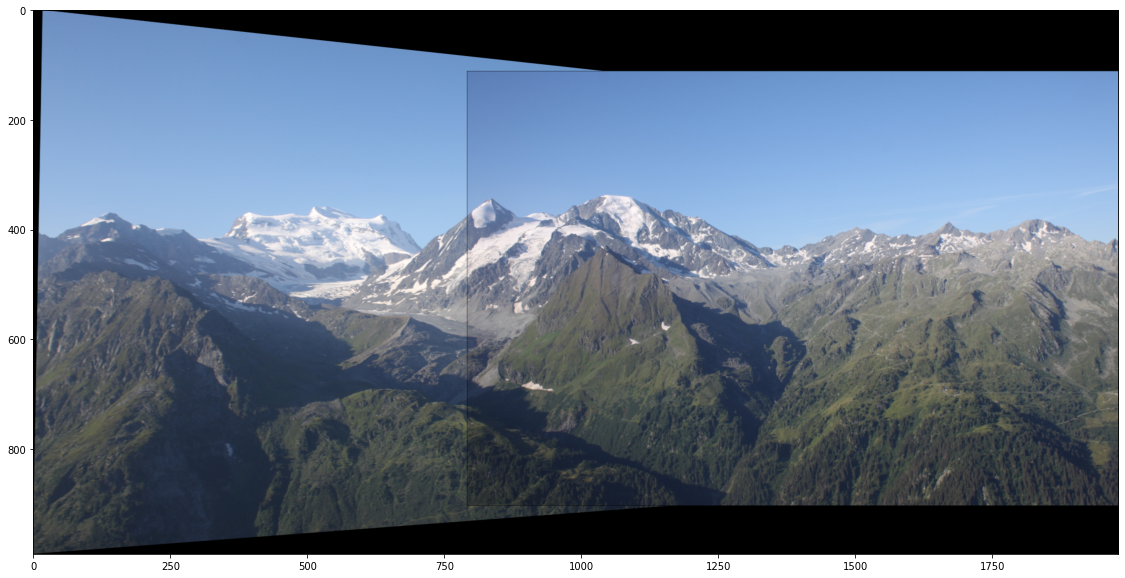

In [8]:
plt.figure(figsize=(20,10))
plt.imshow(result)

#plt.axis('off')
plt.show()

In [9]:
# create panorama
width = img1.shape[1] + img2.shape[1]
height = img1.shape[0] + img2.shape[0]

result = cv2.warpPerspective(img1, H, (width, height))
result[0:img2.shape[0], 0:img2.shape[1]] = img2

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()